In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-04-01 21:41:09.340375: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
img_file = np.flip(images_file)
lb_file = np.flip(labels_file)

In [4]:
images = np.load(img_file)
labels = np.load(lb_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
p = np.random.permutation(len(images))

In [7]:
images = images[p]
labels = labels[p]

In [8]:
labels = labels.astype(np.float64)

In [9]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually

In [10]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [12]:
import json

In [13]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [14]:
X_train = images[0:image_data['84']] 
y_train = labels[0:label_data['84']]
X_val = images[image_data['84']:]
y_val = labels[label_data['84']:]

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    dropout_change_per_layer=0.0,
    num_layers=4,
    output_activation='sigmoid')

2023-04-01 21:41:11.823369: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-01 21:41:12.119382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-01 21:41:12.123542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-01 21:41:12.123562: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-01 21:41:12.126790: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-01 

In [17]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam, SGD

In [18]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [19]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=32, 
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-04-01 21:41:14.287721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-01 21:41:14.305175: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-01 21:41:15.516043: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-01 21:41:16.144232: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-01 21:41:16.818390: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-01 21:41:16.818415: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-01 21:41:16.818483: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-01 21:41:16.900061: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-01 21:41:17.633863: I tensorflow/stream_exec

3/4 [=====================>........] - ETA: 0s - loss: 1.6860 - iou: 2.0354e-04 - iou_thresholded: 2.6049e-04 

2023-04-01 21:41:44.884558: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-04-01 21:41:44.885150: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


4/4 [==============================] - 44s 8s/step - loss: 1.3310 - iou: 1.5287e-04 - iou_thresholded: 2.4249e-04 - val_loss: 0.4359 - val_iou: 4.8247e-05 - val_iou_thresholded: 2.6977e-04
Epoch 2/200
4/4 [==============================] - 9s 3s/step - loss: 0.4365 - iou: 5.5313e-05 - iou_thresholded: 2.3743e-04 - val_loss: 0.4308 - val_iou: 4.9778e-05 - val_iou_thresholded: 2.6977e-04
Epoch 3/200
4/4 [==============================] - 9s 3s/step - loss: 0.2285 - iou: 4.0934e-05 - iou_thresholded: 2.5045e-04 - val_loss: 0.0352 - val_iou: 1.9134e-05 - val_iou_thresholded: 2.6977e-04
Epoch 4/200
4/4 [==============================] - 9s 3s/step - loss: 0.0430 - iou: 1.2191e-05 - iou_thresholded: 2.3326e-04 - val_loss: 0.0142 - val_iou: 6.4811e-05 - val_iou_thresholded: 2.6768e-04
Epoch 5/200
4/4 [==============================] - 9s 3s/step - loss: 0.0234 - iou: 1.1371e-04 - iou_thresholded: 2.3917e-04 - val_loss: 0.0064 - val_iou: 1.6195e-04 - val_iou_thresholded: 2.6977e-04
Epoch 6/200

Epoch 43/200
4/4 [==============================] - 9s 3s/step - loss: 0.0027 - iou: 0.0196 - iou_thresholded: 2.3410e-04 - val_loss: 0.0027 - val_iou: 0.0143 - val_iou_thresholded: 2.6977e-04
Epoch 44/200
4/4 [==============================] - 9s 3s/step - loss: 0.0028 - iou: 0.0157 - iou_thresholded: 2.3687e-04 - val_loss: 0.0028 - val_iou: 0.0148 - val_iou_thresholded: 2.6977e-04
Epoch 45/200
4/4 [==============================] - 9s 3s/step - loss: 0.0027 - iou: 0.0208 - iou_thresholded: 2.4503e-04 - val_loss: 0.0027 - val_iou: 0.0140 - val_iou_thresholded: 2.6977e-04
Epoch 46/200
4/4 [==============================] - 9s 3s/step - loss: 0.0026 - iou: 0.0206 - iou_thresholded: 2.3476e-04 - val_loss: 0.0026 - val_iou: 0.0167 - val_iou_thresholded: 2.6977e-04
Epoch 47/200
4/4 [==============================] - 9s 3s/step - loss: 0.0026 - iou: 0.0223 - iou_thresholded: 2.4550e-04 - val_loss: 0.0026 - val_iou: 0.0174 - val_iou_thresholded: 2.6977e-04
Epoch 48/200
4/4 [=================

Epoch 87/200
4/4 [==============================] - 9s 3s/step - loss: 0.0017 - iou: 0.2084 - iou_thresholded: 0.2475 - val_loss: 0.0028 - val_iou: 0.0982 - val_iou_thresholded: 0.1919
Epoch 88/200
4/4 [==============================] - 9s 3s/step - loss: 0.0020 - iou: 0.2066 - iou_thresholded: 0.2691 - val_loss: 0.0024 - val_iou: 0.0891 - val_iou_thresholded: 0.0815
Epoch 89/200
4/4 [==============================] - 9s 3s/step - loss: 0.0016 - iou: 0.2062 - iou_thresholded: 0.3131 - val_loss: 0.0025 - val_iou: 0.0889 - val_iou_thresholded: 0.0784
Epoch 90/200
4/4 [==============================] - 9s 3s/step - loss: 0.0016 - iou: 0.2011 - iou_thresholded: 0.2537 - val_loss: 0.0019 - val_iou: 0.1229 - val_iou_thresholded: 0.2247
Epoch 91/200
4/4 [==============================] - 9s 3s/step - loss: 0.0013 - iou: 0.2260 - iou_thresholded: 0.4172 - val_loss: 0.0024 - val_iou: 0.1077 - val_iou_thresholded: 0.1051
Epoch 92/200
4/4 [==============================] - 9s 3s/step - loss: 0.00

Epoch 130/200
4/4 [==============================] - 9s 3s/step - loss: 0.0044 - iou: 0.0015 - iou_thresholded: 2.3660e-04 - val_loss: 0.0034 - val_iou: 0.0016 - val_iou_thresholded: 2.6977e-04
Epoch 131/200
4/4 [==============================] - 9s 3s/step - loss: 0.0040 - iou: 0.0021 - iou_thresholded: 2.5231e-04 - val_loss: 0.0042 - val_iou: 5.6859e-04 - val_iou_thresholded: 2.6977e-04
Epoch 132/200
4/4 [==============================] - 9s 3s/step - loss: 0.0046 - iou: 0.0019 - iou_thresholded: 2.4642e-04 - val_loss: 0.0049 - val_iou: 3.2907e-04 - val_iou_thresholded: 2.6977e-04
Epoch 133/200
4/4 [==============================] - 9s 3s/step - loss: 0.0049 - iou: 8.4287e-04 - iou_thresholded: 2.3969e-04 - val_loss: 0.0036 - val_iou: 0.0022 - val_iou_thresholded: 2.6977e-04
Epoch 134/200
4/4 [==============================] - 9s 3s/step - loss: 0.0039 - iou: 0.0015 - iou_thresholded: 2.4817e-04 - val_loss: 0.0033 - val_iou: 0.0016 - val_iou_thresholded: 2.6977e-04
Epoch 135/200
4/4 

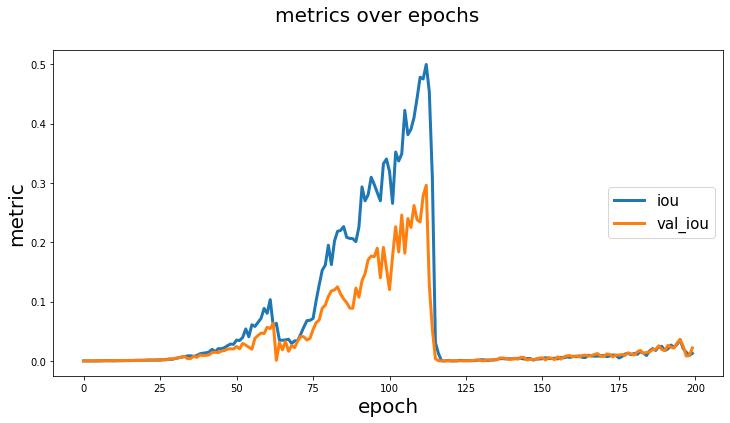

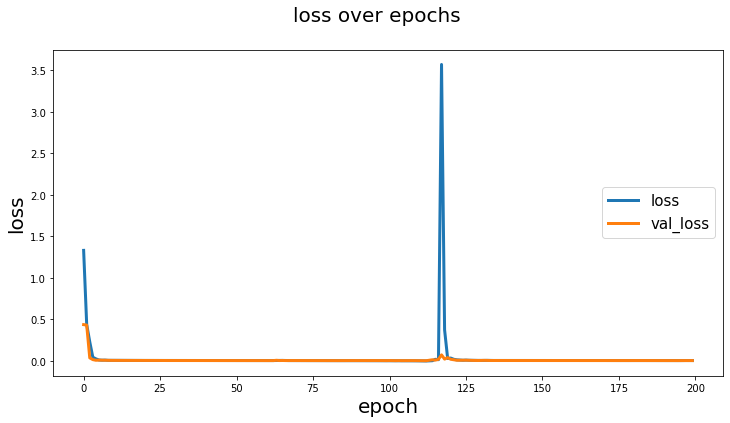

In [20]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [21]:
y_pred = model.predict(X_val)

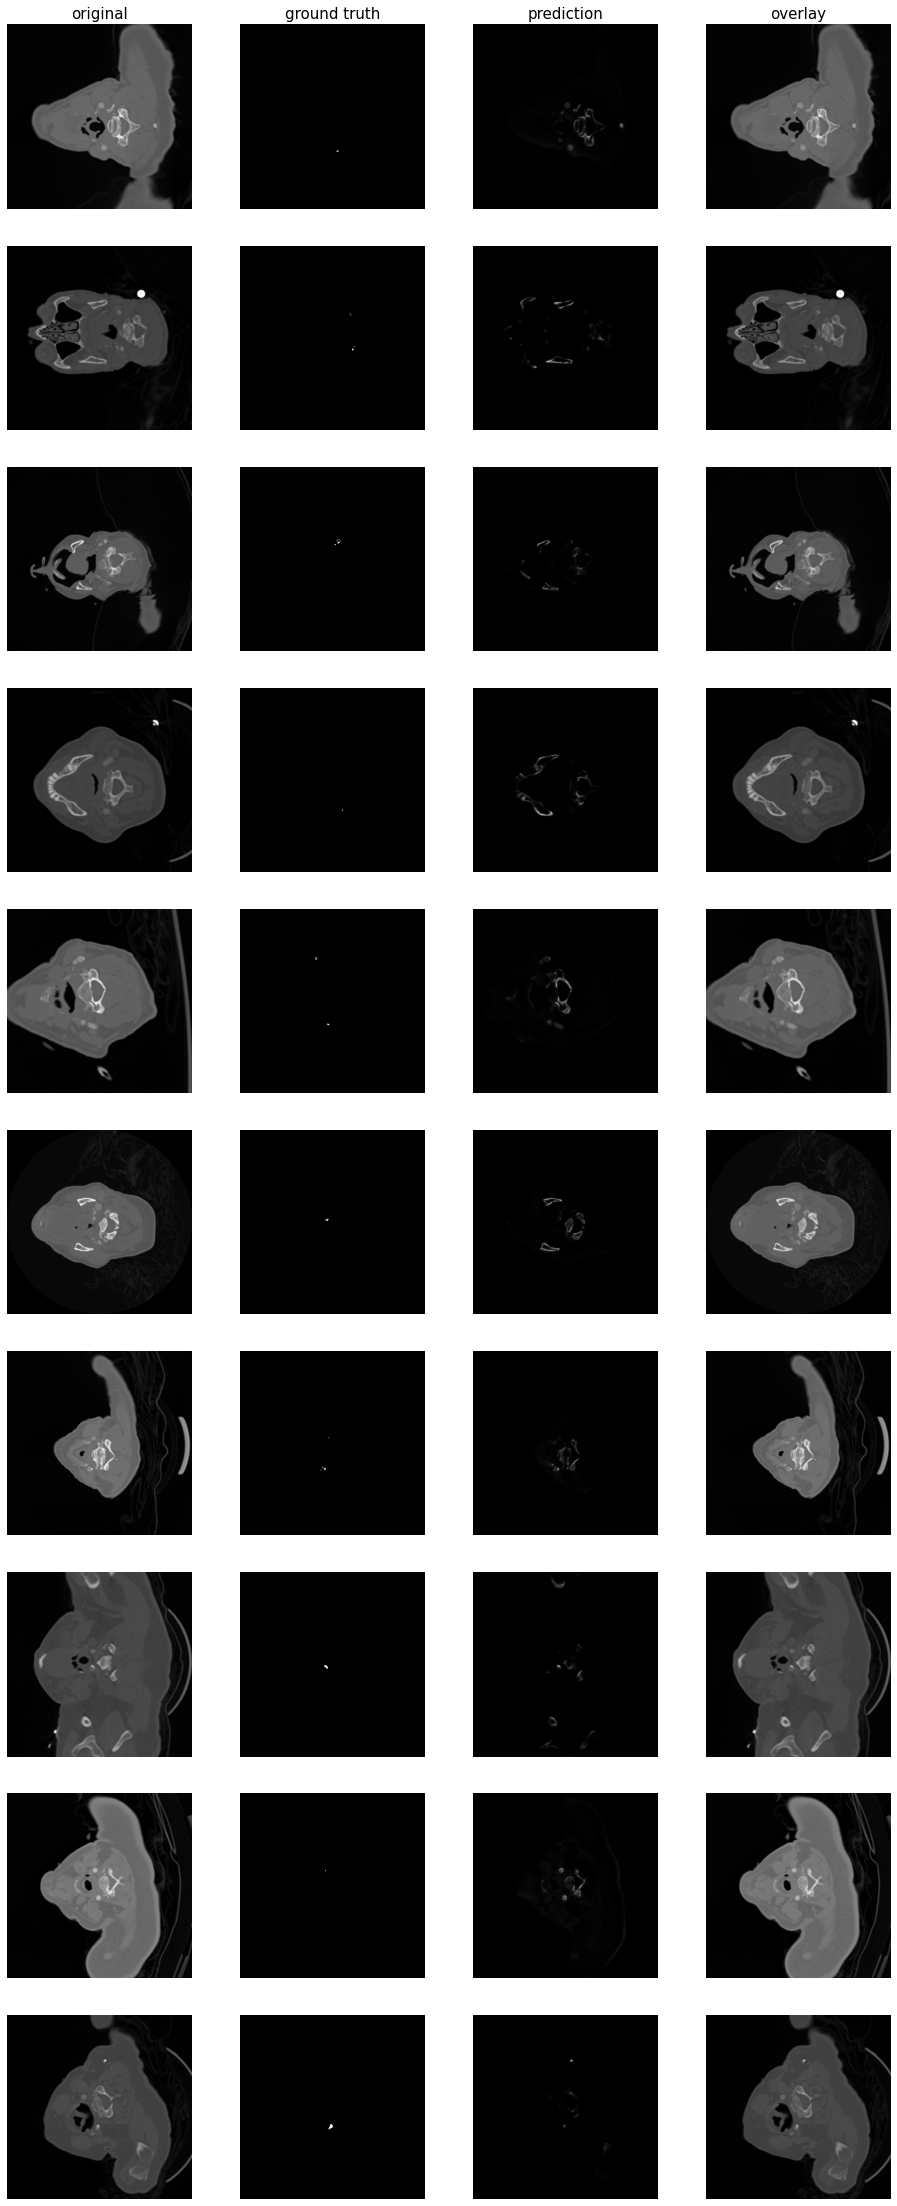

In [22]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [23]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

20/20 [==============================] - 4s 223ms/step - loss: 0.0027 - iou: 0.0221 - iou_thresholded: 5.1833e-04
